# Airbnb data analysis - Mallorca, Spain
In this notebook, we will try to get an idea about the landscape of Airbnb housing in Mallorca, Spain. For that reason, we used the data provided at http://insideairbnb.com/. The datasets describe the listing activity of homestays in the island between April 2020 to April 2021, and it  is basically a snapshot of home-stays  available at a particular time, in this case between 23rd and 25th of April of 2020.

We wanted to answer the following questions:
- What are the top regions with the highest listings in Airbnb?
- Which types of accommodations are mostly offered?
- What are the prices of accommodations listed?
- What are the reviews and ratings of previous travelers?

## A Look at the Data
In order to get a better understanding of the data we will be looking at to answer our questions, let's take a look at some of the characteristics of the datasets that we will use.

First, let's read in the data and necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
listings= pd.read_csv("./listings.csv", low_memory=False, parse_dates=['last_scraped'])
calendar = pd.read_csv("./calendar.csv", parse_dates=['date'])

print(listings.shape)
listings.head()

(17633, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200423151536,2020-04-24,My home at the beach,"Sun, joy, relax, quality, beach & peace. If yo...",It´s a nice refurnished apartment with 50 sq....,"Sun, joy, relax, quality, beach & peace. If yo...",none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.95
1,69998,https://www.airbnb.com/rooms/69998,20200423151536,2020-04-23,COZY HIDEAWAY LOFT... MI AMOR...,Perfect place to escape for a few days of peac...,Cozy loft... mediterranean essence hideaway is...,Perfect place to escape for a few days of peac...,none,( soho-chic bohemian neighborhood of the city ...,...,t,f,strict_14_with_grace_period,t,t,2,2,0,0,1.60
2,100831,https://www.airbnb.com/rooms/100831,20200423151536,2020-04-25,HOUSE IN MALLORCA - WiFi(ET-3045),NaN,House situated in a quiet area of Ca'n Picafor...,House situated in a quiet area of Ca'n Picafor...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,1.18
3,105891,https://www.airbnb.com/rooms/105891,20200423151536,2020-04-24,VILLAGE HOUSE WITH POOL: IDEAL FOR FAMILIES,The house is a street on the outskirts of the ...,"House, ground floor, situated in a small town ...",The house is a street on the outskirts of the ...,none,The village's population does not reach two th...,...,f,f,strict_14_with_grace_period,f,t,2,2,0,0,0.15
4,130669,https://www.airbnb.com/rooms/130669,20200423151536,2020-04-23,Room great apartment,Located in a residential neighbourhood and 10m...,"Located in a beautiful area of palma, (Bonanov...",Located in a residential neighbourhood and 10m...,none,"Located in the center of the city, within minu...",...,t,f,flexible,f,f,3,0,3,0,NaN


In [27]:
#List of the columns' names in the dataset
listings.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


There are many columns that we don't need, so we'll choose just the columns we are interested in

In [4]:
new_listing = listings[['id',
 'listing_url',
'name',
'neighbourhood_cleansed',
'property_type',
 'room_type',
'price',
 'weekly_price',
 'monthly_price',
'minimum_nights',
 'maximum_nights',
'calendar_last_scraped',
'number_of_reviews',
 'number_of_reviews_ltm',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_value',
'reviews_per_month']]



## Top regions with the highest listings in Airbnb

First we'd like to see what are the top regions with the  highest listings 

In [29]:
#Total number of listings
new_listing.id.count()

17633

In [5]:
#List of top regions with the highest offer
regions_ordered = new_listing.groupby(by=['neighbourhood_cleansed']).count()[['id']].sort_values(by= ['id'], ascending=False).reset_index(drop=False)
top_regions = regions_ordered['neighbourhood_cleansed'][:10]
top_regions

0             Pollença
1    Palma de Mallorca
2              Alcúdia
3              Manacor
4             Santanyí
5      Santa Margalida
6             Felanitx
7            Llucmajor
8               Campos
9            Capdepera
Name: neighbourhood_cleansed, dtype: object

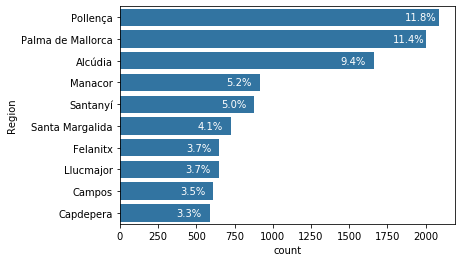

In [208]:
#plot regions
base_color = sns.color_palette()[0]
region_counts = new_listing['neighbourhood_cleansed'].value_counts()
region_order = region_counts.index
sns.countplot(data = new_listing, y = 'neighbourhood_cleansed', color = base_color, order = region_order[:10]);

plt.ylabel("Region")

n_listings= new_listing.shape[0]
for i in range(10):
    count = region_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/n_listings)
    plt.text(count-220, i, pct_string, va = 'center', color = 'w')


## Types of accommodations mostly offered

Next we'd like to know what types of housing each region offers

In [32]:
#room types
new_listing['room_type'].value_counts()/ new_listing['room_type'].count()

Entire home/apt    0.899110
Private room       0.085578
Hotel room         0.014348
Shared room        0.000964
Name: room_type, dtype: float64

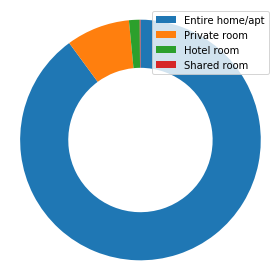

In [33]:
#plot room type
sorted_counts = new_listing['room_type'].value_counts()
labels = sorted_counts.index 
plt.pie(sorted_counts, startangle = 90,
        counterclock = False, wedgeprops = {'width' : 0.4});

plt.legend(labels, loc="best");
plt.axis('square');
plt.tight_layout()

plt.show()


In [34]:
#See where private rooms are concentrated
df_private_room = new_listing.loc[new_listing['room_type'] == 'Private room']
df_private_room.rename(columns = {'neighbourhood_cleansed':'region', 'id':'count'}, inplace = True)
df_private_room.groupby(by=['room_type', 'region']).count()[['count']].sort_values(by= ['room_type', 'count'], ascending=False).head()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


count
room_type    region                  
Private room Palma de Mallorca    692
             Sóller                57
             Calvià                52
             Llucmajor             51
             Santanyí              46

In [6]:
#Top types of properties
properties_ordered = new_listing.groupby(by=['property_type']).count()[['id']].sort_values(by= ['id'], ascending=False).reset_index(drop=False)
top_properties = properties_ordered['property_type'][:10]
properties_ordered.head()

,property_type,id
0,House,5372
1,Villa,4759
2,Apartment,3878
3,Cottage,1002
4,Chalet,696


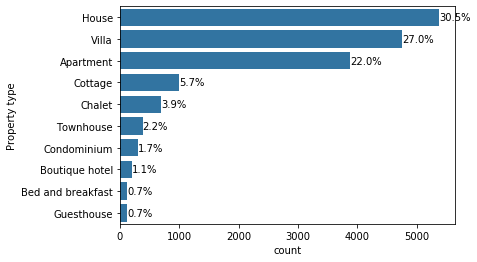

In [36]:
#plot properties
base_color = sns.color_palette()[0]
property_counts = new_listing['property_type'].value_counts()
property_order = property_counts.index
sns.countplot(data = new_listing, y = 'property_type', color = base_color, order = property_order[:10]);

plt.ylabel("Property type")

n_listings= new_listing.shape[0]
for i in range(10):
    count = property_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/n_listings)
    plt.text(count, i, pct_string, va = 'center')
    

In [10]:
df_top3 = new_listing.loc[new_listing['neighbourhood_cleansed'].isin(top_regions[:3])]
df_top3.rename(columns = {'neighbourhood_cleansed':'region', 'id':'count'}, inplace = True)
fff = df_top3.groupby(by=[ 'region', 'property_type']).count()[['count']].sort_values(by= ['region','count'], ascending=False)
fff.groupby(['region']).head(5)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


count
region            property_type       
Pollença          Villa            986
                  House            434
                  Apartment        433
                  Cottage           73
                  Chalet            48
Palma de Mallorca Apartment       1182
                  House            285
                  Villa            158
                  Loft              48
                  Chalet            45
Alcúdia           Apartment        499
                  Villa            475
                  House            408
                  Chalet           111
                  Townhouse         50

## Price 
Let's see here the price of a listing per region and per house_type

In [39]:
new_listing.dtypes


id                          int64
listing_url                object
name                       object
neighbourhood_cleansed     object
property_type              object
room_type                  object
price                      object
weekly_price               object
monthly_price              object
minimum_nights              int64
maximum_nights              int64
calendar_last_scraped      object
number_of_reviews           int64
number_of_reviews_ltm       int64
first_review               object
last_review                object
review_scores_rating      float64
review_scores_value       float64
reviews_per_month         float64
dtype: object

In [40]:
new_listing.isna().sum()

id                            0
listing_url                   0
name                          1
neighbourhood_cleansed        0
property_type                 0
room_type                     0
price                         0
weekly_price              17110
monthly_price             17273
minimum_nights                0
maximum_nights                0
calendar_last_scraped         0
number_of_reviews             0
number_of_reviews_ltm         0
first_review               6841
last_review                6841
review_scores_rating       7072
review_scores_value        7081
reviews_per_month          6841
dtype: int64

The price per night has no missing values while the weekly and monthly prices have many missing values, so we'll just focus on the price per night, but first let's put the price in correct format

In [8]:
new_listing['price'] = new_listing['price'].str.replace('[\$\,]','').astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


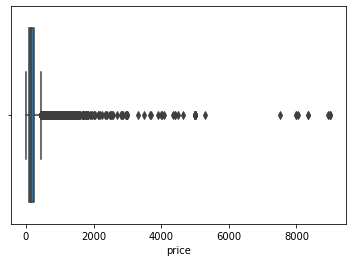

In [47]:
#Exploration of data
sns.boxplot(x = new_listing['price'])

From the boxplot, we can see many outliers but we checked some the listings with highest prices with the prices in official Airbnb website and it match. So our idea is to keep the outliers but we'll zoom in on the data where we have more listings and thus we can understand better the data.

In [48]:
#Price statistics
new_listing.price.describe()

count    17633.000000
mean       213.779901
std        342.103675
min          0.000000
25%         95.000000
50%        149.000000
75%        236.000000
max       9000.000000
Name: price, dtype: float64

Text(0, 0.5, 'Count of listings')

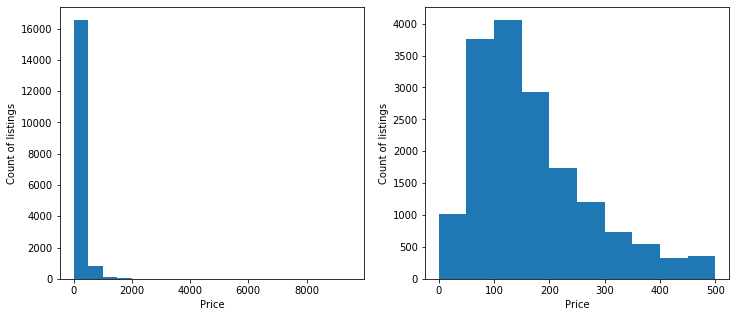

In [49]:
# price plot
plt.figure(figsize = [12, 5])

# histogram on left: full data
plt.subplot(1, 2, 1)
bin_edges = np.arange(0, new_listing['price'].max()+1000, 500)
plt.hist(data = new_listing, x = 'price', bins = bin_edges)
plt.xlabel("Price")
plt.ylabel("Count of listings")
# histogram on right: focus in on bulk of data < 500
plt.subplot(1, 2, 2)
bin_edges = np.arange(0, 500+50, 50)
plt.hist(data = new_listing, x = 'price', bins = bin_edges)
plt.xlabel("Price")
plt.ylabel("Count of listings")


### Price per property type

In [37]:
#property type median price
grouped_property= new_listing.groupby(by=['property_type']).median()[['price']].reset_index(drop=False)
grouped_property.loc[grouped_property['property_type'].isin(top_properties)].sort_values(by =['price'], ascending=False )


,property_type,price
37,Villa,206.0
5,Boutique hotel,198.5
15,Cottage,170.0
13,Chalet,164.5
24,House,150.0
35,Townhouse,119.5
1,Apartment,90.0
3,Bed and breakfast,85.0
14,Condominium,85.0
20,Guesthouse,85.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

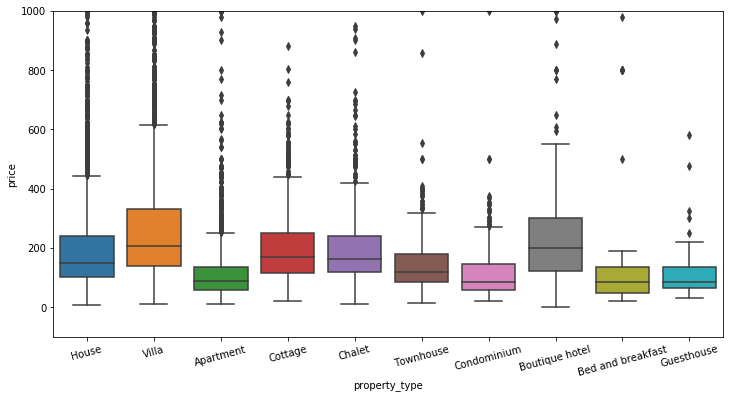

In [26]:
plt.figure(figsize=(12,6))
df= new_listing.loc[new_listing['property_type'].isin(top_properties)]
g = sns.boxplot(data = df, x = 'property_type', y = 'price', order = top_properties)
plt.ylim(-100, 1000)
plt.xticks(rotation = 15)

In [60]:
#room type median price
new_listing.groupby(by=['room_type']).median()[['price']].reset_index(drop=False).rename(columns = {'price': 'median_price'})


,room_type,median_price
0,Entire home/apt,153.0
1,Hotel room,170.0
2,Private room,51.0
3,Shared room,50.0


(-100, 700)

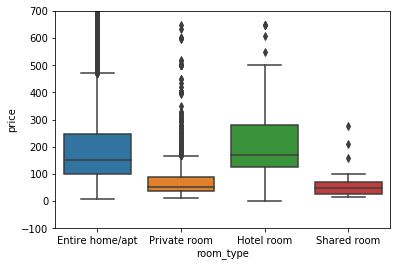

In [36]:
base_color = sns.color_palette()[0]
sns.boxplot(data = new_listing, x = 'room_type', y = 'price')
plt.ylim(-100, 700)

For private rooms, we are particularly interested in the price offered in Palma.

In [66]:
grouped_room= new_listing.groupby(by=['room_type', 'neighbourhood_cleansed']).median()[['price']].reset_index(drop=False)
grouped2 = grouped_room.loc[(grouped_room['neighbourhood_cleansed'] == 'Palma de Mallorca') ]
grouped2.sort_values(by= ['price'], ascending=False)

,room_type,neighbourhood_cleansed,price
68,Hotel room,Palma de Mallorca,144.0
33,Entire home/apt,Palma de Mallorca,130.0
110,Private room,Palma de Mallorca,45.0
133,Shared room,Palma de Mallorca,39.5


### Price per region

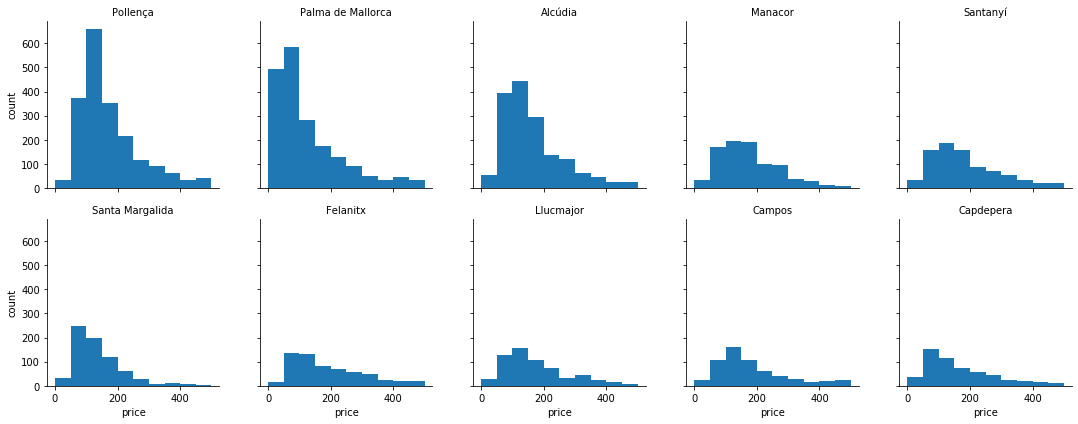

In [46]:
bin_edges = np.arange(0, 500+50, 50)
df= new_listing.loc[new_listing['neighbourhood_cleansed'].isin(top_regions)]
g = sns.FacetGrid(data = df, col = 'neighbourhood_cleansed', col_wrap = 5, col_order = top_regions)
g.map(plt.hist, "price", bins = bin_edges)
g.set_titles('{col_name}')
g.set_ylabels('count')

In [12]:
#median price per region
grouped_region= new_listing.groupby(by=['neighbourhood_cleansed']).median()[['price']].reset_index(drop=False).sort_values(by =['price'], ascending=False)
grouped_region.rename(columns = {'neighbourhood_cleansed':'region', 'price':'median_price'})[:10]


,region,median_price
16,Deyá,237.5
18,Esporles,208.0
3,Andratx,200.0
30,Marratxí,195.0
8,Bunyola,190.0
10,Calvià,183.0
39,Sant Joan,183.0
34,Petra,180.0
17,Escorca,180.0
45,Selva,178.5


### prices, region, property

In [67]:
grouped_neighbourhood= new_listing.groupby(by=['property_type', 'neighbourhood_cleansed']).mean()[['price']].reset_index(drop=False)
grouped = grouped_neighbourhood.loc[grouped_neighbourhood['neighbourhood_cleansed'].isin(top_regions) & grouped_neighbourhood['property_type'].isin(top_properties[:3]) ]
grouped.sort_values(by= ['property_type', 'price'], ascending=False)

,property_type,neighbourhood_cleansed,price
611,Villa,Capdepera,495.400000
631,Villa,Palma de Mallorca,453.987342
618,Villa,Felanitx,373.976608
624,Villa,Llucmajor,349.031088
642,Villa,Santanyí,296.709821
625,Villa,Manacor,292.272189
599,Villa,Alcúdia,276.343158
610,Villa,Campos,244.103030
633,Villa,Pollença,236.904665
640,Villa,Santa Margalida,200.126506


### Price along time

To get an idea about the prices along the time, we'll use calendar dataset

In [94]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,441723,2020-04-24,f,69.0,$69.00,3.0,21.0
1,11547,2020-04-24,f,75.0,$75.00,6.0,1125.0
2,11547,2020-04-25,t,75.0,$75.00,6.0,1125.0
3,11547,2020-04-26,t,75.0,$75.00,6.0,1125.0
4,11547,2020-04-27,t,75.0,$75.00,6.0,1125.0


In [95]:

calendar.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
price                    float64
adjusted_price            object
minimum_nights           float64
maximum_nights           float64
dtype: object

In [96]:
# Check NaN
calendar.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    9
maximum_nights    9
dtype: int64

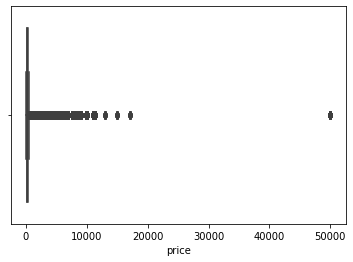

In [97]:
#Exploration of data: checking for outliers
sns.boxplot(x = calendar['price'])

In [98]:
calendar.price.describe()

count    6.436045e+06
mean     2.665629e+02
std      6.428054e+02
min      0.000000e+00
25%      1.040000e+02
50%      1.690000e+02
75%      2.750000e+02
max      4.999900e+04
Name: price, dtype: float64

We'll take just the prices where the listings are available

In [101]:
calendar['available'].astype(str)
calendar_available= calendar.loc[(calendar['available'] == "t")]
calendar_available['price'].describe()

count    3.849703e+06
mean     2.394674e+02
std      4.989189e+02
min      8.000000e+00
25%      1.000000e+02
50%      1.600000e+02
75%      2.600000e+02
max      4.999900e+04
Name: price, dtype: float64

The maximum price is too high to be true, a quick check to Airbnb site proves that as well. Maximum price could reach 10000 euros but no more. Thus, we'll remove the outliers.

In [103]:
# Applying IQR rule for removing outliers
Q1 = calendar_available['price'].quantile(0.25)
Q3 = calendar_available['price'].quantile(0.75)
IQR = Q3 - Q1
calendar_wo = calendar_available[calendar_available['price'].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)] 
calendar_wo['price'].describe()


count    3.587281e+06
mean     1.770358e+02
std      1.042650e+02
min      8.000000e+00
25%      1.000000e+02
50%      1.500000e+02
75%      2.310000e+02
max      5.000000e+02
Name: price, dtype: float64

In [119]:
calendar_wo.sort_values(by= ['price'], ascending=False)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,week
841749,9128450,2021-04-01,t,500.0,$500.00,5.0,1125.0,2021,4,3
2111074,18803663,2021-03-25,t,500.0,$500.00,4.0,1125.0,2021,3,3
2111090,18803663,2021-04-10,t,500.0,$500.00,4.0,1125.0,2021,4,5
2111089,18803663,2021-04-09,t,500.0,$500.00,4.0,1125.0,2021,4,4
2111088,18803663,2021-04-08,t,500.0,$500.00,4.0,1125.0,2021,4,3
...,...,...,...,...,...,...,...,...,...,...
846854,9904278,2021-04-10,t,8.0,$8.00,7.0,1125.0,2021,4,5
846861,9904278,2021-04-17,t,8.0,$8.00,7.0,1125.0,2021,4,5
846847,9904278,2021-04-03,t,8.0,$8.00,7.0,1125.0,2021,4,5
846846,9904278,2021-04-02,t,8.0,$8.00,7.0,1125.0,2021,4,4


(array([737546., 737607., 737669., 737730., 737791., 737850., 737911.]),
 <a list of 7 Text xticklabel objects>)

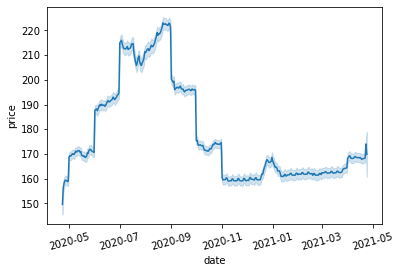

In [117]:
sns.lineplot(data = calendar_wo, x= 'date', y='price', estimator='mean')
plt.xticks(rotation = 15)

Text(0.5, 0, 'Month (Jan=1, Dec=12)')

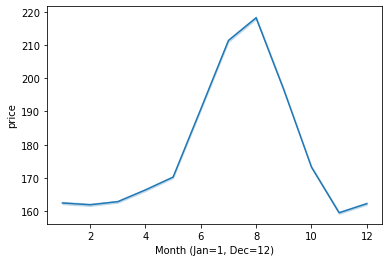

In [121]:
#variation of mean price per month
sns.lineplot(data = calendar_wo, x= calendar_wo.date.dt.month, y='price', estimator='mean')
plt.xlabel("Month (Jan=1, Dec=12)")

Text(0.5, 0, 'Day (Mon=1, Sun=6)')

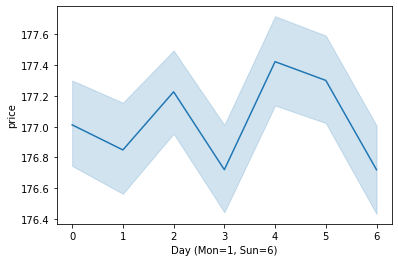

In [124]:
#variation of mean price per week day
sns.lineplot(data = calendar_wo, x= calendar_wo.date.dt.dayofweek, y='price', estimator='mean')
plt.xlabel("Day (Mon=1, Sun=6)")

## Reviews 
Now, let's see what the reviewers say and what they appreciate most

In [134]:
reviews = listings [['id',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']]

reviews.head()

,id,neighbourhood_cleansed,property_type,room_type,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,11547,Calvià,Apartment,Entire home/apt,100,13,2011-08-23,2019-10-20,96.0,10.0,9.0,10.0,10.0,10.0,10.0
1,69998,Palma de Mallorca,Loft,Entire home/apt,161,5,2012-01-24,2020-03-15,98.0,10.0,10.0,10.0,10.0,10.0,10.0
2,100831,Santa Margalida,House,Entire home/apt,110,24,2012-08-26,2020-01-25,100.0,10.0,10.0,10.0,10.0,10.0,10.0
3,105891,Maria de la Salut,Townhouse,Entire home/apt,14,2,2012-06-19,2019-09-03,97.0,10.0,10.0,10.0,10.0,9.0,10.0
4,130669,Palma de Mallorca,Apartment,Private room,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Overall rating

In [137]:
reviews.review_scores_rating.describe()

count    10561.000000
mean        93.250544
std          9.212100
min         20.000000
25%         90.000000
50%         96.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

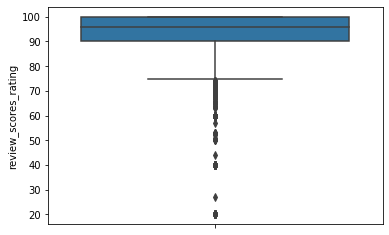

In [191]:
sns.boxplot(data = reviews, y = 'review_scores_rating')

### Ratings per room type

In [196]:
room_rating = pd.DataFrame()
room_rating['overall rating'] = round(reviews.groupby('room_type')['review_scores_rating'].mean()/10, 2)
room_rating['accuracy'] = round(reviews.groupby('room_type')['review_scores_accuracy'].mean(), 2)
room_rating['cleanliness'] = round(reviews.groupby('room_type')['review_scores_cleanliness'].mean(), 2)
room_rating['check-in'] = round(reviews.groupby('room_type')['review_scores_checkin'].mean(), 2)
room_rating['communication'] = round(reviews.groupby('room_type')['review_scores_communication'].mean(), 2)
room_rating['location'] = round(reviews.groupby('room_type')['review_scores_location'].mean(), 2)
room_rating['value'] = round(reviews.groupby('room_type')['review_scores_value'].mean(), 2)

room_rating.sort_values('overall rating', ascending = False)[:10]

,overall rating,accuracy,cleanliness,check-in,communication,location,value
room_type,,,,,,,
Hotel room,9.44,9.52,9.68,9.65,9.59,9.50,9.32
Entire home/apt,9.33,9.52,9.41,9.67,9.63,9.46,9.17
Private room,9.26,9.52,9.35,9.67,9.58,9.45,9.22
Shared room,7.04,7.40,7.00,7.60,7.40,9.00,8.80


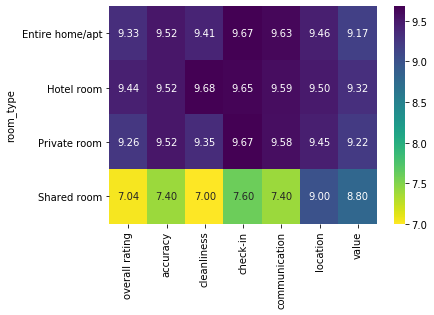

In [213]:
sns.heatmap(data = room_rating, annot = True, fmt = '.2f', cmap = 'viridis_r')

### Property types ratings

In [201]:
reviews_pt= reviews.loc[reviews['property_type'].isin(top_properties)]

property_rating = pd.DataFrame()
property_rating['overall rating'] = round(reviews_pt.groupby('property_type')['review_scores_rating'].mean()/10, 2)
property_rating['accuracy'] = round(reviews_pt.groupby('property_type')['review_scores_accuracy'].mean(), 2)
property_rating['cleanliness'] = round(reviews_pt.groupby('property_type')['review_scores_cleanliness'].mean(), 2)
property_rating['check-in'] = round(reviews_pt.groupby('property_type')['review_scores_checkin'].mean(), 2)
property_rating['communication'] = round(reviews_pt.groupby('property_type')['review_scores_communication'].mean(), 2)
property_rating['location'] = round(reviews_pt.groupby('property_type')['review_scores_location'].mean(), 2)
property_rating['value'] = round(reviews_pt.groupby('property_type')['review_scores_value'].mean(), 2)

property_rating.sort_values('overall rating', ascending = False)[:10]

,overall rating,accuracy,cleanliness,check-in,communication,location,value
property_type,,,,,,,
Cottage,9.57,9.68,9.61,9.78,9.79,9.50,9.41
Townhouse,9.50,9.74,9.63,9.85,9.84,9.51,9.33
Boutique hotel,9.49,9.50,9.62,9.75,9.53,9.54,9.24
Guesthouse,9.46,9.65,9.60,9.81,9.80,9.51,9.26
Chalet,9.45,9.55,9.48,9.73,9.67,9.46,9.26
Bed and breakfast,9.40,9.63,9.72,9.66,9.65,9.40,9.46
House,9.40,9.58,9.47,9.71,9.66,9.44,9.23
Condominium,9.33,9.54,9.45,9.72,9.69,9.58,9.23
Villa,9.28,9.44,9.34,9.57,9.53,9.34,9.12


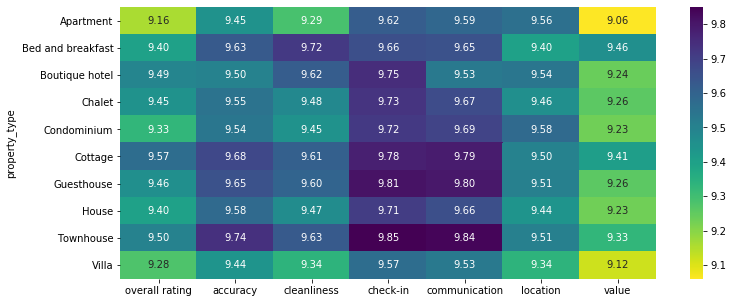

In [202]:
plt.figure(figsize = [12, 5])
sns.heatmap(property_rating, annot = True , fmt = '.2f', cmap = 'viridis_r')

### Ratings per neighborhood

In [203]:
reviews_region= reviews.loc[reviews['neighbourhood_cleansed'].isin(top_regions)]

region_rating = pd.DataFrame()
region_rating['overall rating'] = round(reviews_region.groupby('neighbourhood_cleansed')['review_scores_rating'].mean()/10, 2)
region_rating['accuracy'] = round(reviews_region.groupby('neighbourhood_cleansed')['review_scores_accuracy'].mean(), 2)
region_rating['cleanliness'] = round(reviews_region.groupby('neighbourhood_cleansed')['review_scores_cleanliness'].mean(), 2)
region_rating['check-in'] = round(reviews_region.groupby('neighbourhood_cleansed')['review_scores_checkin'].mean(), 2)
region_rating['communication'] = round(reviews_region.groupby('neighbourhood_cleansed')['review_scores_communication'].mean(), 2)
region_rating['location'] = round(reviews_region.groupby('neighbourhood_cleansed')['review_scores_location'].mean(), 2)
region_rating['value'] = round(reviews_region.groupby('neighbourhood_cleansed')['review_scores_value'].mean(), 2)

region_rating.sort_values('overall rating', ascending = False)[:10]

,overall rating,accuracy,cleanliness,check-in,communication,location,value
neighbourhood_cleansed,,,,,,,
Manacor,9.51,9.60,9.54,9.71,9.73,9.46,9.34
Campos,9.43,9.57,9.44,9.72,9.70,9.36,9.23
Felanitx,9.41,9.55,9.46,9.68,9.65,9.42,9.21
Llucmajor,9.31,9.45,9.38,9.69,9.64,9.08,9.19
Santa Margalida,9.31,9.57,9.42,9.75,9.65,9.45,9.22
Santanyí,9.30,9.52,9.33,9.70,9.62,9.63,9.04
Pollença,9.21,9.48,9.33,9.61,9.59,9.57,9.09
Palma de Mallorca,9.18,9.47,9.28,9.64,9.60,9.47,9.08
Capdepera,9.16,9.28,9.22,9.56,9.39,9.47,8.99


Text(86.5, 0.5, 'region')

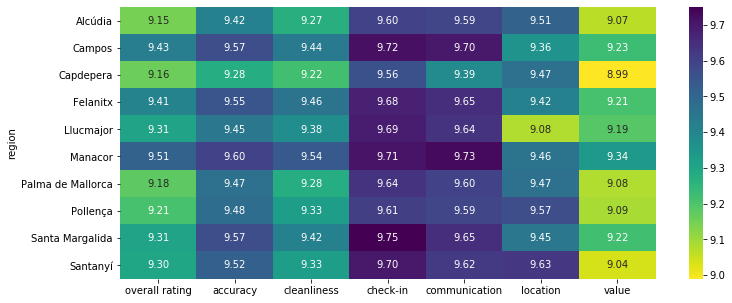

In [214]:
plt.figure(figsize = [12, 5])
sns.heatmap(region_rating, annot = True , fmt = '.2f', cmap = 'viridis_r')
plt.ylabel('region')